In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [4]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
for parameters in model.parameters():
    parameters.requires_grad = False
model.features[32] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
model.features[34] = nn.Conv2d(512, 2, kernel_size=3, stride=1, padding=1)
model.avgpool = nn.AdaptiveAvgPool2d(1)  #生成 (10, 1, 1)的输出 10是n_channels 
model.classifier = nn.Linear(2, 2)

In [49]:
#Create datasets and dataloaders

input_size=224
batch_size = 16
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_train = datasets.ImageFolder(root='hymenoptera_data/train/',
                                    transform=train_transforms)

dataset_valid = datasets.ImageFolder(root='hymenoptera_data/val/',
                                    transform=valid_transforms)



train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, 
                                          shuffle=True)

In [9]:
def train_batch_loss(model, loss_function, x, y, opt=None):
    loss = loss_function(model(x), y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return np.array(loss.item()), np.array(len(x))

In [10]:
def valid_batch_loss(model, loss_function, x, y):
    output = model(x)
    loss = loss_function(output, y)
    return np.array(loss.item()), np.array(len(x))

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.0001)
epochs = 200

device = torch.device("cuda")
model.to(device)

for e in range(epochs):
    model.train()
    loss, number_of_data = zip(*[train_batch_loss(model, criterion, 
                                                  x.to(device), 
                                                  y.to(device), 
                                                  optimizer) for x, y in train_loader])
    train_loss = np.sum(np.multiply(loss,number_of_data)) / np.sum(number_of_data)
    model.eval()
    with torch.no_grad():
            loss, number_of_data = zip(*[valid_batch_loss(model, criterion, 
                                                          x.to(device), 
                                                          y.to(device)) for x, y in valid_loader])
            validation_loss = np.sum(np.multiply(loss, number_of_data)) / np.sum(number_of_data)
    print(f"[Epoch {e+1}/{epochs}]"
          f"Train loss:{train_loss:.6f}\t"
          f"Validation loss:{validation_loss:.6f}\t")                                        

[Epoch 1/200]Train loss:0.672187	Validation loss:0.621751	
[Epoch 2/200]Train loss:0.597997	Validation loss:0.538408	
[Epoch 3/200]Train loss:0.530890	Validation loss:0.487071	
[Epoch 4/200]Train loss:0.485008	Validation loss:0.476698	
[Epoch 5/200]Train loss:0.445446	Validation loss:0.447690	
[Epoch 6/200]Train loss:0.433395	Validation loss:0.459542	
[Epoch 7/200]Train loss:0.429136	Validation loss:0.430120	
[Epoch 8/200]Train loss:0.421199	Validation loss:0.426100	
[Epoch 9/200]Train loss:0.431728	Validation loss:0.413454	
[Epoch 10/200]Train loss:0.406948	Validation loss:0.423826	
[Epoch 11/200]Train loss:0.384329	Validation loss:0.421796	
[Epoch 12/200]Train loss:0.384473	Validation loss:0.418036	
[Epoch 13/200]Train loss:0.376010	Validation loss:0.402393	
[Epoch 14/200]Train loss:0.379759	Validation loss:0.406920	
[Epoch 15/200]Train loss:0.371411	Validation loss:0.440513	
[Epoch 16/200]Train loss:0.353950	Validation loss:0.420152	
[Epoch 17/200]Train loss:0.348583	Validation loss

[Epoch 138/200]Train loss:0.245578	Validation loss:0.333715	
[Epoch 139/200]Train loss:0.231412	Validation loss:0.326552	
[Epoch 140/200]Train loss:0.201545	Validation loss:0.306569	
[Epoch 141/200]Train loss:0.237983	Validation loss:0.344475	
[Epoch 142/200]Train loss:0.222292	Validation loss:0.288165	
[Epoch 143/200]Train loss:0.218464	Validation loss:0.300659	
[Epoch 144/200]Train loss:0.236496	Validation loss:0.321142	
[Epoch 145/200]Train loss:0.247937	Validation loss:0.316231	
[Epoch 146/200]Train loss:0.218593	Validation loss:0.282079	
[Epoch 147/200]Train loss:0.228432	Validation loss:0.375908	
[Epoch 148/200]Train loss:0.228130	Validation loss:0.294712	
[Epoch 149/200]Train loss:0.225590	Validation loss:0.302157	
[Epoch 150/200]Train loss:0.243995	Validation loss:0.362638	
[Epoch 151/200]Train loss:0.237198	Validation loss:0.270858	
[Epoch 152/200]Train loss:0.239485	Validation loss:0.346279	
[Epoch 153/200]Train loss:0.219827	Validation loss:0.306242	
[Epoch 154/200]Train los

In [14]:
save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\Class_activation_mapping\VGG_fine_tuned_on_hymenoptera.pt"
torch.save(model.state_dict(), save_path)

In [50]:
save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\Class_activation_mapping\VGG_fine_tuned_on_hymenoptera.pt"
state_dict = torch.load(save_path)
model = models.vgg19()
model.features[32] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
model.features[34] = nn.Conv2d(512, 2, kernel_size=3, stride=1, padding=1)
model.avgpool = nn.AdaptiveAvgPool2d(1)  #生成 (10, 1, 1)的输出 10是n_channels 
model.classifier = nn.Linear(2, 2)
model.load_state_dict(state_dict)
model.eval()
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [51]:
class get_feature_map:
    features = None
    
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.float32
torch.Size([1, 3, 224, 224])
(2, 14, 14)
(2, 2)
(2, 196)
(224, 224, 2)


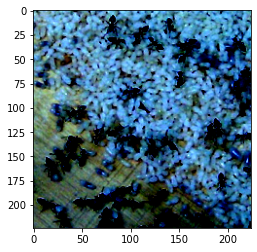

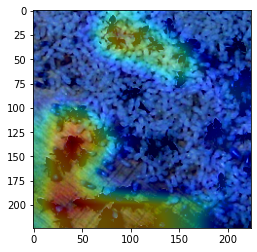

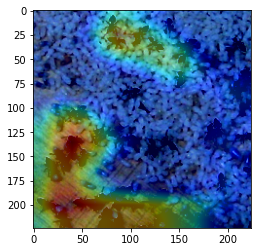

In [75]:
#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=1, 
                                           shuffle=True,
                                           num_workers=1)
im, lab = next(iter(valid_loader))
im = im.type(torch.cuda.FloatTensor).to(device)

print(im.dtype)
print(im.shape)
model.to(device)
feature_map = get_feature_map(model.features[-3])
logits = model(im)
feature_map.remove()
feature_map = feature_map.features.cpu().detach().numpy().squeeze()
print(feature_map.shape)
weights = list(model.parameters())[-2].data.cpu().detach().numpy()  
print(weights.shape)  # (2, 2) (class number, channel number)
cam = weights @ feature_map.reshape(2, -1)  # (2, 14X14)
print(cam.shape)
cam = cam.reshape(2, 14, 14).transpose(1, 2, 0)
cam = cv2.resize(cam, (224, 224))
print(cam.shape)

im = im.cpu().numpy()
im = np.squeeze(im).transpose(1, 2, 0)

plt.figure()
plt.imshow(im)

plt.figure()
plt.imshow(im)
plt.imshow(cam[:,:,0], alpha=0.4, cmap="jet")

plt.figure()
plt.imshow(im)
plt.imshow(cam[:,:,1], alpha=0.4, cmap="jet")